In [2]:
from sklearn.model_selection import train_test_split
from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklift.metrics import qini_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
import seaborn as sns

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
0,0,control,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,...,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,1,control,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,...,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,2,treatment,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,...,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,0
3,3,treatment,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,...,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,0
4,4,treatment,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,...,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,0


In [7]:
train.loc[train['treatment_group']=='treatment', 'treatment'] = 1
train['treatment'].fillna(0, inplace=True)
test.loc[test['treatment_group']=='treatment', 'treatment'] = 1
test['treatment'].fillna(0, inplace=True)

In [24]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (600000, 54)
Test shape: (900000, 53)


In [25]:
print('Train N|A:', train.isna().sum().sum())
print('Test N|A:', test.isna().sum().sum())

Train N|A: 0
Test N|A: 0


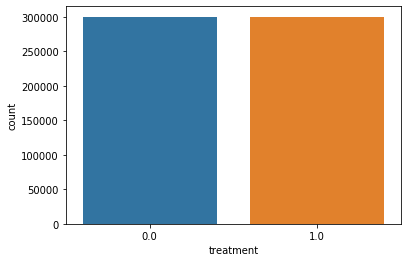

In [99]:
sns.countplot(x='treatment', data=train)

In [21]:
print(train.treatment.loc[train['treatment'] == 1].count()) 
print(train.treatment.loc[train['treatment'] == 0].count()) 
print(test.treatment.loc[test['treatment'] == 1].count()) 
print(test.treatment.loc[test['treatment'] == 0].count()) 

300368
299632
449632
450368


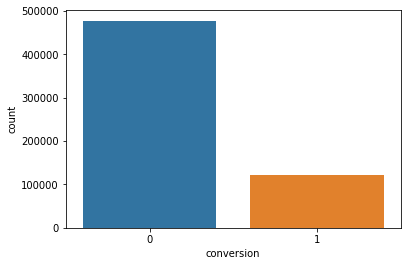

In [98]:
sns.countplot(x='conversion', data=train)

In [23]:
print(train.conversion.loc[train['conversion'] == 1].count()) 
print(train.conversion.loc[train['conversion'] == 0].count()) 

122514
477486


In [ ]:
X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    train.drop(['id', 'treatment_group', 'treatment','conversion'], axis=1),
    train.treatment, train.conversion,
    stratify=train.conversion,
    test_size=0.3,
    random_state=42
)

In [33]:
sm = SoloModel(lgb.LGBMClassifier(random_state=42))
sm.fit(
    X=X_train, 
    y=y_train, 
    treatment=trmnt_train
)
uplift_ct = sm.predict(X_val)
auqc = qini_auc_score(y_val, uplift_ct, trmnt_val) 
print(f"Qini coefficient: {auqc:.4f}")

Qini coefficient: 0.2298


In [37]:
treatment_model = lgb.LGBMClassifier(random_state=42, silent=True)
control_model = lgb.LGBMClassifier(random_state=42, silent=True)
tm = TwoModels(treatment_model, control_model, method='vanilla')
tm = tm.fit(X_train, y_train, trmnt_train)
uplift_ct = tm.predict(X_val)
auqc = qini_auc_score(y_val, uplift_ct, trmnt_val) 
print(f"Qini coefficient: {auqc:.4f}")

Qini coefficient: 0.2392


In [39]:
treatment_model = lgb.LGBMClassifier(random_state=42, silent=True)
control_model = lgb.LGBMClassifier(random_state=42, silent=True)
tm = TwoModels(treatment_model, control_model, method='ddr_control')
tm = tm.fit(X_train, y_train, trmnt_train)
uplift_ct = tm.predict(X_val)
auqc = qini_auc_score(y_val, uplift_ct, trmnt_val) 
print(f"Qini coefficient: {auqc:.4f}")

Qini coefficient: 0.2288


In [59]:
treatment_model = lgb.LGBMClassifier(random_state=42, silent=True)
control_model = lgb.LGBMClassifier(random_state=42, silent=True)
tm = TwoModels(treatment_model, control_model, method='ddr_treatment')
tm = tm.fit(X_train, y_train, trmnt_train)
uplift_ct = tm.predict(X_val)
auqc = qini_auc_score(y_val, uplift_ct, trmnt_val) 
print(f"Qini coefficient: {auqc:.4f}")

Qini coefficient: 0.2273


In [71]:
est_trmnt = lgb.LGBMClassifier(random_state=42, silent=True)
est_ctrl = lgb.LGBMClassifier(random_state=42, silent=True)
model = TwoModels(estimator_trmnt = est_trmnt , estimator_ctrl = est_ctrl, method='vanilla')
pipe = Pipeline([
    ('model', model)
])


In [72]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'model', 'model__estimator_ctrl__boosting_type', 'model__estimator_ctrl__class_weight', 'model__estimator_ctrl__colsample_bytree', 'model__estimator_ctrl__importance_type', 'model__estimator_ctrl__learning_rate', 'model__estimator_ctrl__max_depth', 'model__estimator_ctrl__min_child_samples', 'model__estimator_ctrl__min_child_weight', 'model__estimator_ctrl__min_split_gain', 'model__estimator_ctrl__n_estimators', 'model__estimator_ctrl__n_jobs', 'model__estimator_ctrl__num_leaves', 'model__estimator_ctrl__objective', 'model__estimator_ctrl__random_state', 'model__estimator_ctrl__reg_alpha', 'model__estimator_ctrl__reg_lambda', 'model__estimator_ctrl__silent', 'model__estimator_ctrl__subsample', 'model__estimator_ctrl__subsample_for_bin', 'model__estimator_ctrl__subsample_freq', 'model__estimator_ctrl', 'model__estimator_trmnt__boosting_type', 'model__estimator_trmnt__class_weight', 'model__estimator_trmnt__colsample_bytree', 'model__estimator_trm

In [85]:
def scorer(clf, X, y):
    trmnt = trmnt_val
    return qini_auc_score(y, clf.predict(X), X.treatment) 

In [94]:
param_grid = {
    'model__estimator_trmnt__num_leaves': [10, 20, 30, 40, 50],
    'model__estimator_ctrl__num_leaves': [10, 20, 30, 40, 50],
    'model__estimator_trmnt__boosting_type': ['gbdt', 'dart'],
    'model__estimator_ctrl__boosting_type': ['gbdt', 'dart'],
}
fit_params={
    'model__treatment':train.treatment
}
gs = RandomizedSearchCV(pipe, param_grid, scoring=scorer,
n_iter = 10, cv = 3, random_state=42)
gs.fit(train.drop(['id', 'treatment_group', 'conversion'], axis=1), train.conversion, **fit_params)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('model',
                                              TwoModels(estimator_ctrl=LGBMClassifier(boosting_type='gbdt',
                                                                                      class_weight=None,
                                                                                      colsample_bytree=1.0,
                                                                                      importance_type='split',
                                                                                      learning_rate=0.1,
                                                                                      max_depth=-1,
                                                                                      min_child_samples=20,
                                                                                      min_child_weight=0.00

In [96]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.23963213838494848 with params: {'model__estimator_trmnt__num_leaves': 50, 'model__estimator_trmnt__boosting_type': 'gbdt', 'model__estimator_ctrl__num_leaves': 30, 'model__estimator_ctrl__boosting_type': 'gbdt'} 


In [97]:
sub = pd.DataFrame()
sub['id'] = test.iloc[:,0]
sub['pred'] = gs.predict(test.drop(['id', 'treatment_group'], axis=1).values)
sub.to_csv('sub.csv', index=False)